# Analysis of probe models

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import torch

from data_management import fetch_dataset

In [2]:
from model import ClassifierWithTTA
from safetensors import safe_open

def load_model(classifier_hidden_layers):
    folder = {
                0: "linear_probe",
                2: "vit2_probe",
                4: "vit4_probe"
             }.get(classifier_hidden_layers)
    
    tensors = {}
    with safe_open(f"{folder}/checkpoint-62500/model.safetensors", framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

    model = ClassifierWithTTA(classifier_hidden_layers=classifier_hidden_layers)
    model.load_state_dict(tensors)

    return model

W0913 12:03:38.351000 896 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [3]:
linear_model = load_model(0)
vit2_model = load_model(2)
vit4_model = load_model(4)

#### Double check that the encoders did not train

In [7]:
linear_params = list(linear_model.embedding.parameters())
vit2_params = list(vit4_model.embedding.parameters())
vit4_params = list(vit4_model.embedding.parameters())

In [9]:
linTo2 = []
linTo4 = []

for i in range( len(linear_params)):
    linTo2.append( (linear_params[i] == vit2_params[i]).all())
    linTo4.append( (linear_params[i] == vit4_params[i]).all())
    

In [10]:
all(linTo2)

True

In [11]:
all(linTo4)

True

Looks good.

## Baseline accuracy

This is on the validation set, which I also used as a development set.

In [7]:
from data_management import fetch_dataset_from_hf

train, val = fetch_dataset_from_hf() 


In [30]:
import torchmetrics

def compute_accuracy(model, data):
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=200)
    dl = torch.utils.data.DataLoader(data, batch_size=64)

    model.to('mps')
    
    for batch in iter(dl):
        preds = model.forward(batch[0].to('mps')).logits
        accuracy.update(preds.cpu(), batch[1])

    model.to('cpu')
    return accuracy


In [31]:
compute_accuracy(linear_model, val).compute()

tensor(0.5168)

In [32]:
compute_accuracy(vit2_model, val).compute()

tensor(0.7095)

In [33]:
compute_accuracy(vit4_model, val).compute()

tensor(0.7030)

These accuracies aren't great (in particular the linear probing one), but I think that they are sufficient for investigation of TTA

## Accuracy on corrupted datasets:

In [2]:
from model import ClassifierWithTTA
from safetensors import safe_open

def load_model(classifier_hidden_layers):
    folder = {
                0: "linear_probe",
                2: "vit2_probe",
                4: "vit4_probe"
             }.get(classifier_hidden_layers)
    
    tensors = {}
    with safe_open(f"{folder}/checkpoint-62500/model.safetensors", framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

    model = ClassifierWithTTA(classifier_hidden_layers=classifier_hidden_layers)
    model.load_state_dict(tensors)

    return model

import torchmetrics

def compute_accuracy(model, data):
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=200)
    dl = torch.utils.data.DataLoader(data, batch_size=64)

    model.to('mps')
    
    for batch in iter(dl):
        preds = model.forward(batch[0].to('mps')).logits
        accuracy.update(preds.cpu(), batch[1])

    model.to('cpu')
    return accuracy


W0910 13:26:06.524000 1141 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [4]:
%run dataset_files/metadata.py

all_corruptions = [None] + corruption_names_train + corruption_names_val

In [5]:
results = []
for num_layers in [0,2,4]:
    model = load_model(num_layers)
    for corruption_name in all_corruptions:
        if corruption_name is None:
            fname = 'dataset_files/uncorrupted_valid.npz'
        else:
            fname = f'dataset_files/corrupted_{corruption_name}_severity5_valid.npz'
    
        data = fetch_dataset(fname)
        acc = compute_accuracy(model, data)
        results.append({'model_layers': num_layers, 'corruption': corruption_name, 'accuracy': acc.compute()})

        del data
        print(num_layers, corruption_name)
    del model

0 None
0 gaussian_noise
0 shot_noise
0 impulse_noise
0 defocus_blur
0 glass_blur
0 motion_blur
0 zoom_blur
0 snow
0 frost
0 fog
0 brightness
0 contrast
0 elastic_transform
0 pixelate
0 jpeg_compression
0 speckle_noise
0 gaussian_blur
0 spatter
0 saturate
2 None
2 gaussian_noise
2 shot_noise
2 impulse_noise
2 defocus_blur
2 glass_blur
2 motion_blur
2 zoom_blur
2 snow
2 frost
2 fog
2 brightness
2 contrast
2 elastic_transform
2 pixelate
2 jpeg_compression
2 speckle_noise
2 gaussian_blur
2 spatter
2 saturate
4 None
4 gaussian_noise
4 shot_noise
4 impulse_noise
4 defocus_blur
4 glass_blur
4 motion_blur
4 zoom_blur
4 snow
4 frost
4 fog
4 brightness
4 contrast
4 elastic_transform
4 pixelate
4 jpeg_compression
4 speckle_noise
4 gaussian_blur
4 spatter
4 saturate


In [26]:
accuracy_results = pd.DataFrame(results)
accuracy_results.accuracy = accuracy_results.accuracy.map(lambda x: x.item())
accuracy_results = accuracy_results.fillna('None')

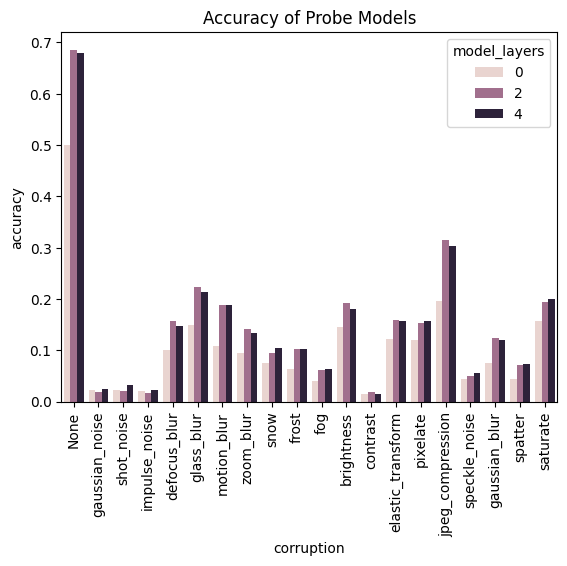

In [33]:
plt.title('Accuracy of Probe Models')
sns.barplot(accuracy_results, x="corruption", y="accuracy", hue="model_layers")
_=plt.xticks(rotation=90)

Ok. There is a _substantial_ drop in accuracy for all models and all noise types. For the most part, the gap between linear and vit performance persists across corruptions.

In [35]:
accuracy_results.to_csv('accuracy_probe.csv')

### Accuracy of full trained models:

In [37]:
def load_model_full(classifier_hidden_layers):
    folder = {
                0: "linear_full",
                2: "vit2_full",
                4: "vit4_full"
             }.get(classifier_hidden_layers)
    
    tensors = {}
    with safe_open(f"{folder}/checkpoint-37500/model.safetensors", framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

    model = ClassifierWithTTA(classifier_hidden_layers=classifier_hidden_layers)
    model.load_state_dict(tensors)

    return model

In [38]:
results_full = []
for num_layers in [0,2,4]:
    model = load_model_full(num_layers)
    for corruption_name in all_corruptions:
        if corruption_name is None:
            fname = 'dataset_files/uncorrupted_valid.npz'
        else:
            fname = f'dataset_files/corrupted_{corruption_name}_severity5_valid.npz'
    
        data = fetch_dataset(fname)
        acc = compute_accuracy(model, data)
        results_full.append({'model_layers': num_layers, 'corruption': corruption_name, 'accuracy': acc.compute()})

        del data
        print(num_layers, corruption_name)
    del model

0 None
0 gaussian_noise
0 shot_noise
0 impulse_noise
0 defocus_blur
0 glass_blur
0 motion_blur
0 zoom_blur
0 snow
0 frost
0 fog
0 brightness
0 contrast
0 elastic_transform
0 pixelate
0 jpeg_compression
0 speckle_noise
0 gaussian_blur
0 spatter
0 saturate
2 None
2 gaussian_noise
2 shot_noise
2 impulse_noise
2 defocus_blur
2 glass_blur
2 motion_blur
2 zoom_blur
2 snow
2 frost
2 fog
2 brightness
2 contrast
2 elastic_transform
2 pixelate
2 jpeg_compression
2 speckle_noise
2 gaussian_blur
2 spatter
2 saturate
4 None
4 gaussian_noise
4 shot_noise
4 impulse_noise
4 defocus_blur
4 glass_blur
4 motion_blur
4 zoom_blur
4 snow
4 frost
4 fog
4 brightness
4 contrast
4 elastic_transform
4 pixelate
4 jpeg_compression
4 speckle_noise
4 gaussian_blur
4 spatter
4 saturate


In [39]:
accuracy_results_full = pd.DataFrame(results_full)
accuracy_results_full.accuracy = accuracy_results_full.accuracy.map(lambda x: x.item())
accuracy_results_full = accuracy_results_full.fillna('None')

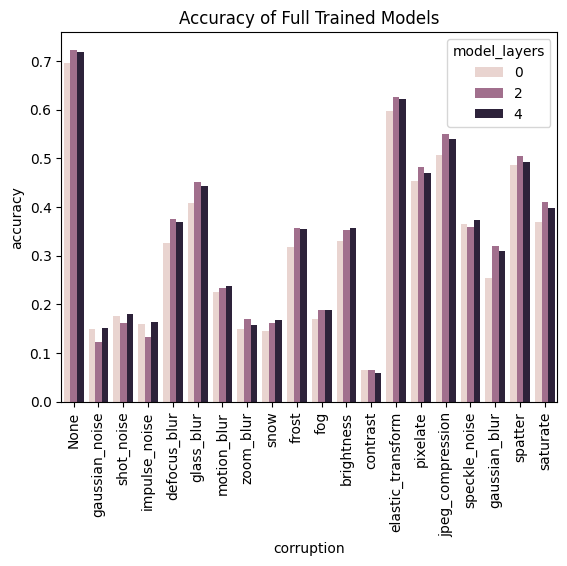

In [41]:
plt.title('Accuracy of Full Trained Models')
sns.barplot(accuracy_results_full, x="corruption", y="accuracy", hue="model_layers")
_=plt.xticks(rotation=90)

Interesting. Full model finetuning has a significantly better baseline performance on corrupted datasets. Also, the gap between linear and vit models has vanished.

A priori, I could have seen arguments in either direction that improved specialization of the model to the dataset leads to better / worse performance. I'd like to double check this at some point, maybe with a different dataset.

In [42]:
accuracy_results_full.to_csv('results_data/accuracy_full.csv')

## Test-time adaptation

### Visualize the effects of noise on embeddings

In [5]:
model = load_model(0)

In [3]:
data = fetch_dataset(f'dataset_files/corrupted_gaussian_noise_severity5_valid.npz')
inputs_corrupted = torch.stack( 3*[data.tensors[0][1001]] )

data = fetch_dataset(f'dataset_files/uncorrupted_valid.npz')
inputs_uncorrupted = torch.stack( 3*[data.tensors[0][1001]] )

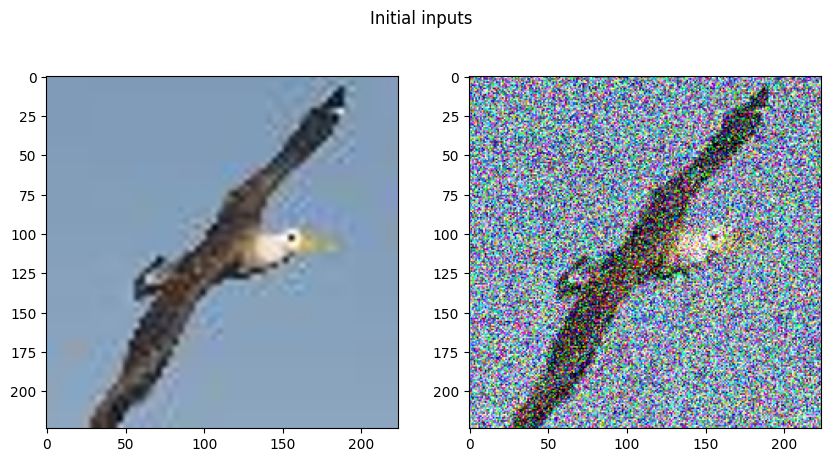

In [5]:
figsize(10,5)
plt.subplots(1,2)
plt.suptitle('Initial inputs')
plt.subplot(1,2,1)
plt.imshow(inputs_uncorrupted[0].permute([1,2,0]).detach())

plt.subplot(1,2,2)
plt.imshow(inputs_corrupted[0].permute([1,2,0]).detach())

There is some aliasing present. Likely from the resizing step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5443678..2.207448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0865972..1.7933382].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8177551..2.16182].


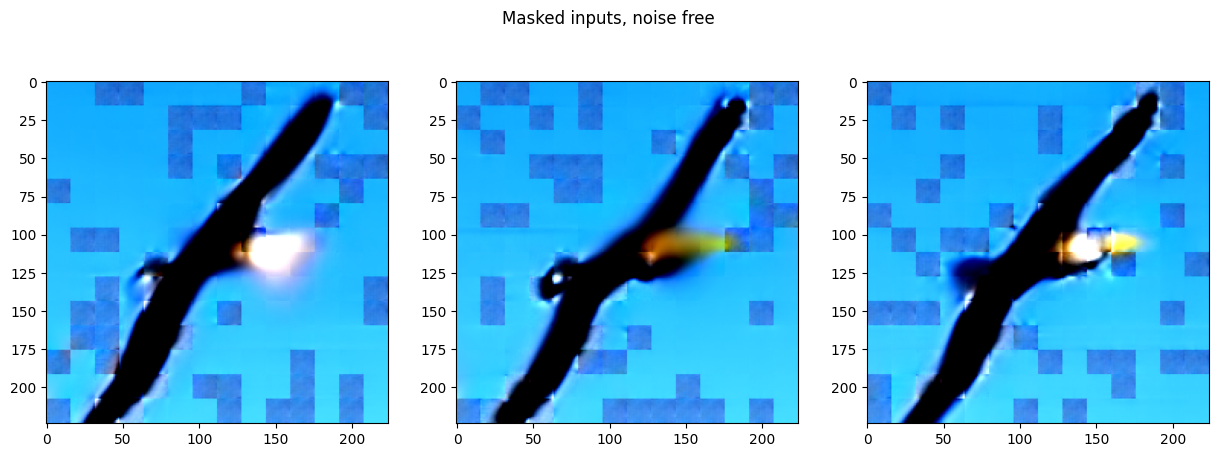

In [6]:
model.embedding.enable_masking()
preds = model.embedding( inputs_uncorrupted)

figsize(15,5)
plt.subplots(1,3)
plt.suptitle('Masked inputs, noise free')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow( model.embedding.unpatchify(preds.logits)[i].permute([1,2,0]).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3748689..1.7050781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4317371..1.6529045].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1504921..1.8552871].


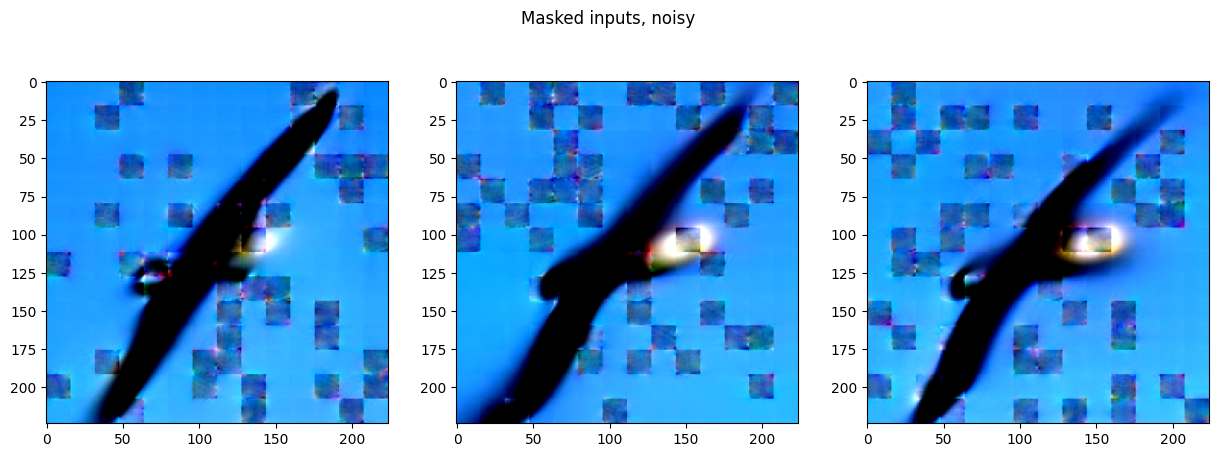

In [7]:
model.embedding.enable_masking()
preds = model.embedding( inputs_corrupted)

figsize(15,5)
plt.subplots(1,3)
plt.suptitle('Masked inputs, noisy')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow( model.embedding.unpatchify(preds.logits)[i].permute([1,2,0]).detach().cpu())

Similar reconstruction. Seemingly more primative from noisy version.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3038204..2.4763317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3038218..2.476333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3038201..2.4763348].


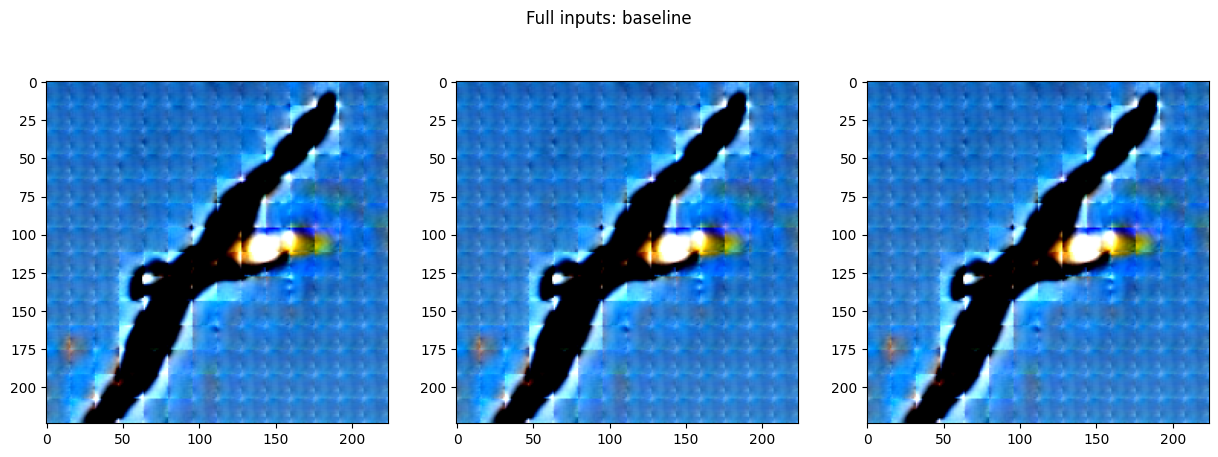

In [8]:
model.embedding.disable_masking()
preds = model.embedding(inputs_uncorrupted)

figsize(15,5)
plt.subplots(1,3)
plt.suptitle('Full inputs: baseline')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow( model.embedding.unpatchify(preds.logits)[i].permute([1,2,0]).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8682927..2.2285428].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8682919..2.228544].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8682926..2.228543].


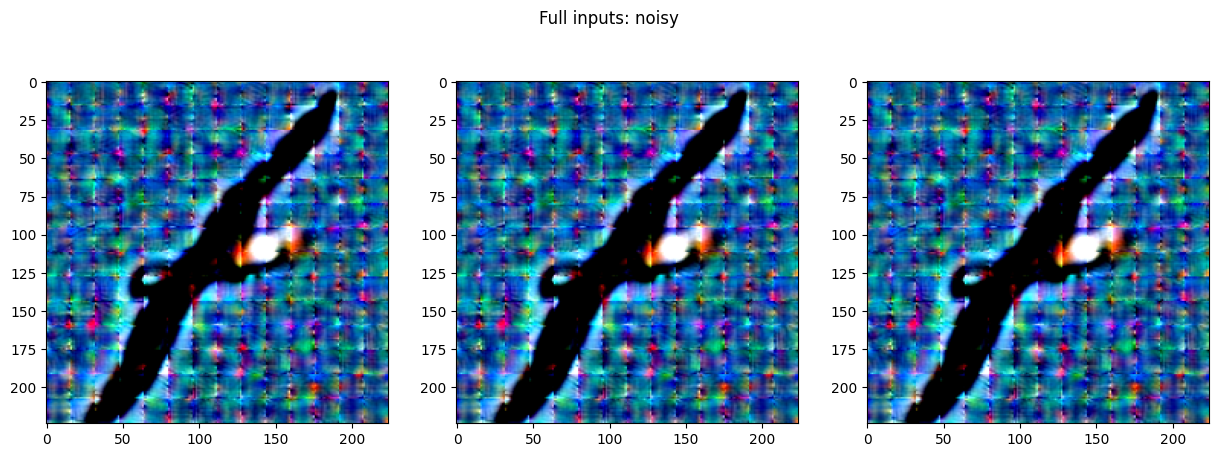

In [9]:
model.embedding.disable_masking()
preds = model.embedding(inputs_corrupted)

figsize(15,5)
plt.subplots(1,3)
plt.suptitle('Full inputs: noisy')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow( model.embedding.unpatchify(preds.logits)[i].permute([1,2,0]).detach().cpu())

Strong impact of the noise on the backgroud pixels, some, but less obvious impact on the other pixels, particularly near the head.

(note: these embeddings _do not_ necessarily align with the image itself: they decoder outputs, but _would not_ be trained on during MAE training. The masked patches (none here) are the ones that would be trained on.

Note also that the reconstructed images are pre-processed versions: we using identical pre-processing in both classification and reconstruction steps.

### Adaptation - example run-through

In [3]:
data = fetch_dataset(f'dataset_files/corrupted_gaussian_noise_severity5_valid.npz')
input_corrupted = data.tensors[0][1001][None, :, :, :]

data = fetch_dataset(f'dataset_files/uncorrupted_valid.npz')
input_uncorrupted = data.tensors[0][1001][None, :, :, :]

label = data.tensors[1][1001]
print(label)

tensor(20)


In [4]:
from training import test_time_adaptation

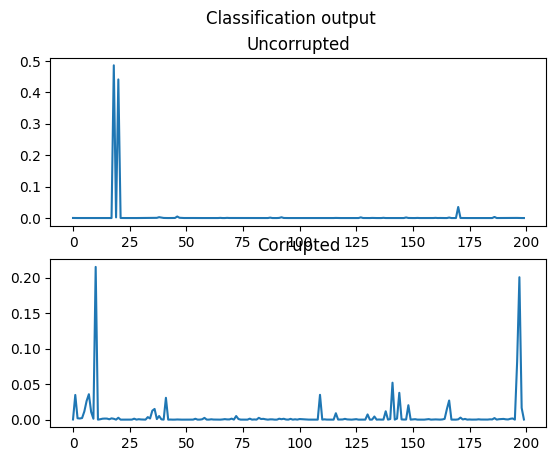

In [5]:
model = load_model(0)

plt.subplots(2,1)
plt.suptitle('Classification output')
plt.subplot(2,1,1)
plt.title('Uncorrupted')
plt.plot( torch.nn.functional.softmax( model( input_uncorrupted.to(model.embedding.device)).logits[0], 0).detach())

plt.subplot(2,1,2)
plt.title('Corrupted')
plt.plot( torch.nn.functional.softmax( model( input_corrupted.to(model.embedding.device)).logits[0], 0).detach())

In this case, the uncorrupted classification was wrong: #18 beats #20, but it is a close second. Corrupted classification is massively off.

Perform adaptation using hugging face default hyper-parameters.

In [6]:
adapt_uncorrupted = load_model(0)
test_time_adaptation(adapt_uncorrupted, input_uncorrupted, steps=20, repeats=128,
                     disable_tqdm=False, logging_strategy='epoch', optimizer=None)

/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8542058..2.2334986].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9992747..2.2026286].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9240384..2.1110382].


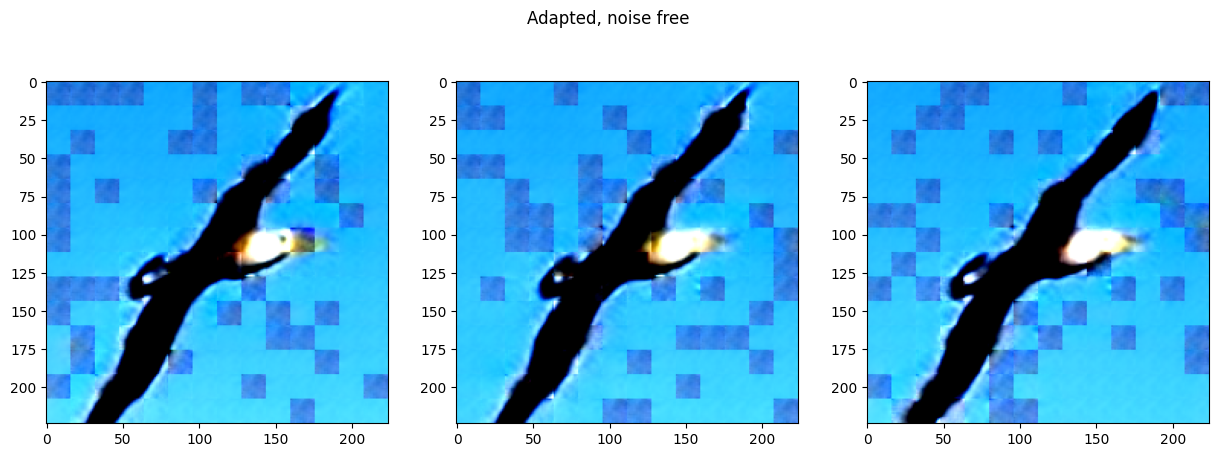

In [8]:
preds = adapt_uncorrupted.embedding( torch.concat(3*[input_uncorrupted.to(adapt_uncorrupted.embedding.device)]))

figsize(15,5)
plt.subplots(1,3)
plt.suptitle('Adapted, noise free')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow( adapt_uncorrupted.embedding.unpatchify(preds.logits)[i].permute([1,2,0]).detach().cpu())

This captures the whole shape better than the un-finetuned, and also learns details like the eye and tail.

In [9]:
adapt_corrupted = load_model(0)
test_time_adaptation(adapt_corrupted, input_corrupted, steps=20, repeats=128,
                     disable_tqdm=False, logging_strategy='epoch', optimizer=None)

/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4982541..1.793924].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3817463..1.8194277].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5648735..1.7662503].


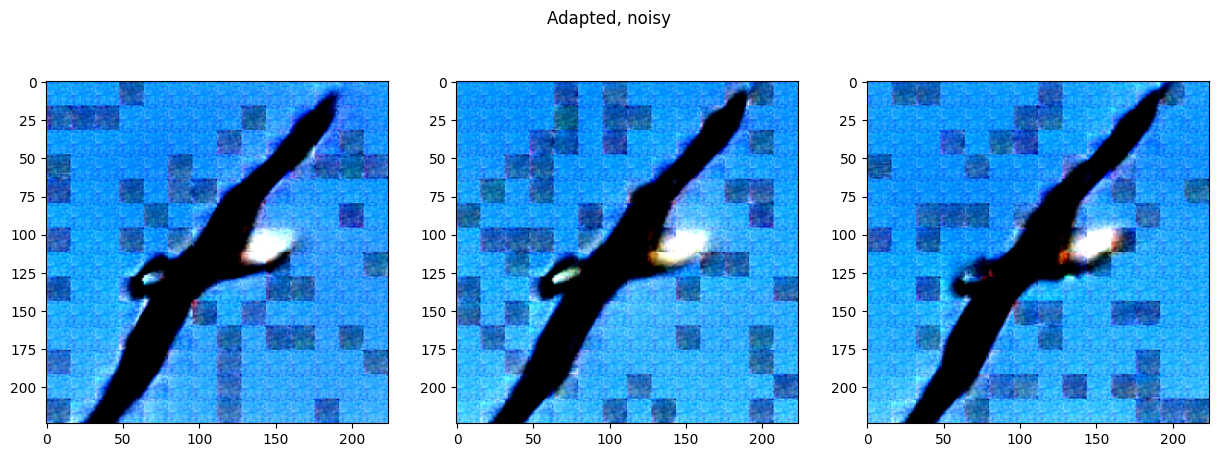

In [10]:
preds = adapt_corrupted.embedding( torch.concat(3*[input_corrupted.to(adapt_corrupted.embedding.device)]))

figsize(15,5)
plt.subplots(1,3)
plt.suptitle('Adapted, noisy')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow( adapt_corrupted.embedding.unpatchify(preds.logits)[i].permute([1,2,0]).detach().cpu())

Similarly, learns the underlying structure of the image quite well. There is some residual noise effect on the background, and certainly less resolution of the birds head.

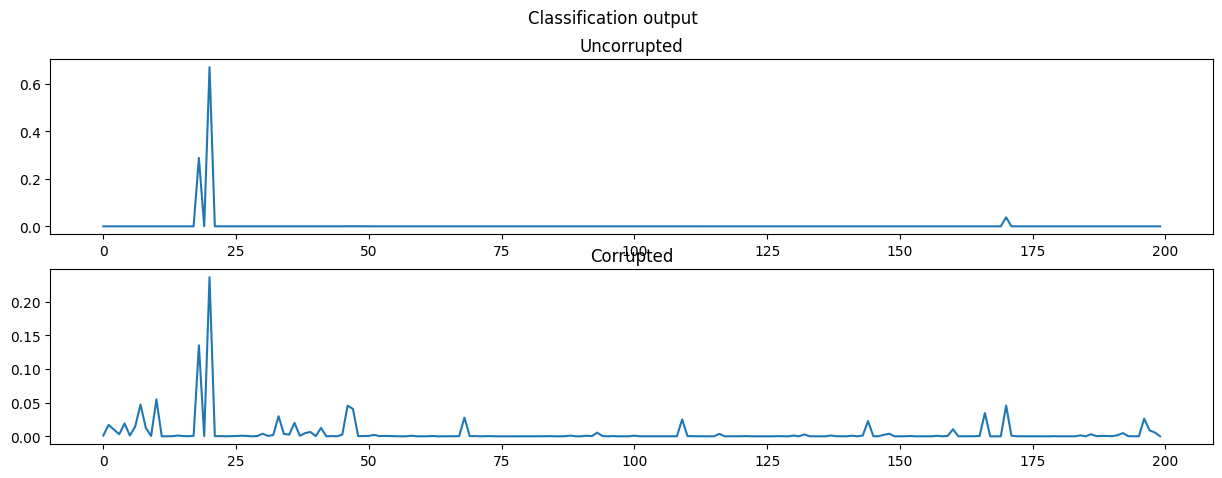

In [13]:
adapt_corrupted.to('mps')
adapt_uncorrupted.to('mps')

plt.subplots(2,1)
plt.suptitle('Classification output')
plt.subplot(2,1,1)
plt.title('Uncorrupted')
plt.plot( torch.nn.functional.softmax( adapt_uncorrupted( input_uncorrupted.to('mps')).logits[0], 0).detach().cpu())

plt.subplot(2,1,2)
plt.title('Corrupted')
plt.plot( torch.nn.functional.softmax( adapt_corrupted( input_corrupted.to('mps')).logits[0], 0).detach().cpu())

Classification is now aligned for the adapted models, with both producing the correct answer.

#### Make sure that the classifier parameters were not changed by adaptation

In [17]:
baseline = load_model(0)

In [18]:
params_base = list(baseline.classifier.parameters())

In [19]:
params_ft = list(adapt_corrupted.classifier.parameters())

In [20]:
for i in range(len(params_base)):
    print( (params_base[i] == params_ft[i].to('cpu')).all())

tensor(True)
tensor(True)
tensor(True)
tensor(True)


Yes. Unchanged.

#### That example works well.

However, I observed during training that the hyper-parameter settings from the paper do not show the same level of adaptation.

In [28]:
adapt_corrupted = load_model(0)
test_time_adaptation(adapt_corrupted, input_corrupted, steps=20, repeats=128,
                     disable_tqdm=False, logging_strategy='epoch', optimizer='SGD')

The train error does not decrease under these parameter settings.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1273003..1.4816315].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1100268..1.4651276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1055187..1.5811986].


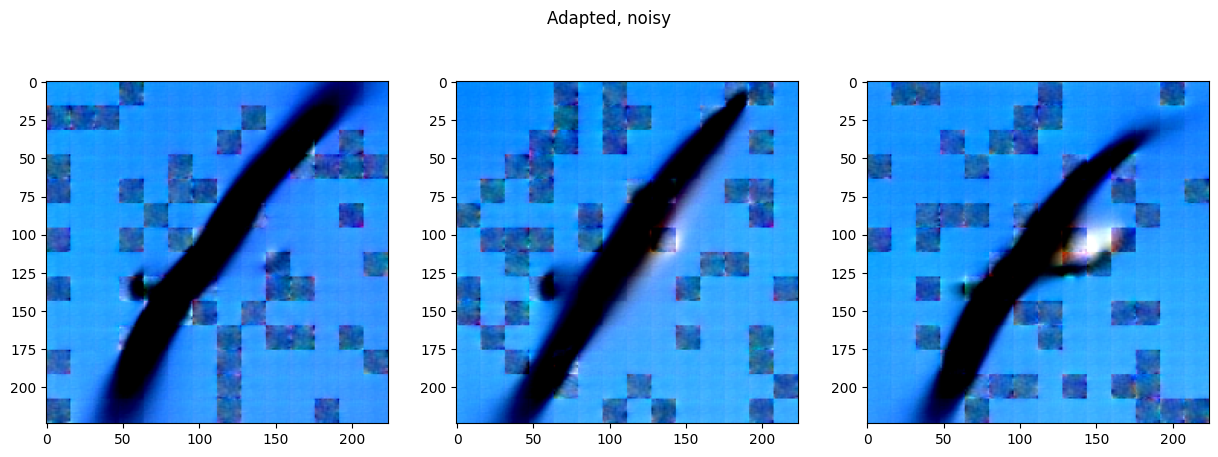

In [29]:
preds = adapt_corrupted.embedding( torch.concat(3*[input_corrupted.to(adapt_corrupted.embedding.device)]))

figsize(15,5)
plt.subplots(1,3)
plt.suptitle('Adapted, noisy')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow( adapt_corrupted.embedding.unpatchify(preds.logits)[i].permute([1,2,0]).detach().cpu())

Autoencoding doesn't really seem to improve.

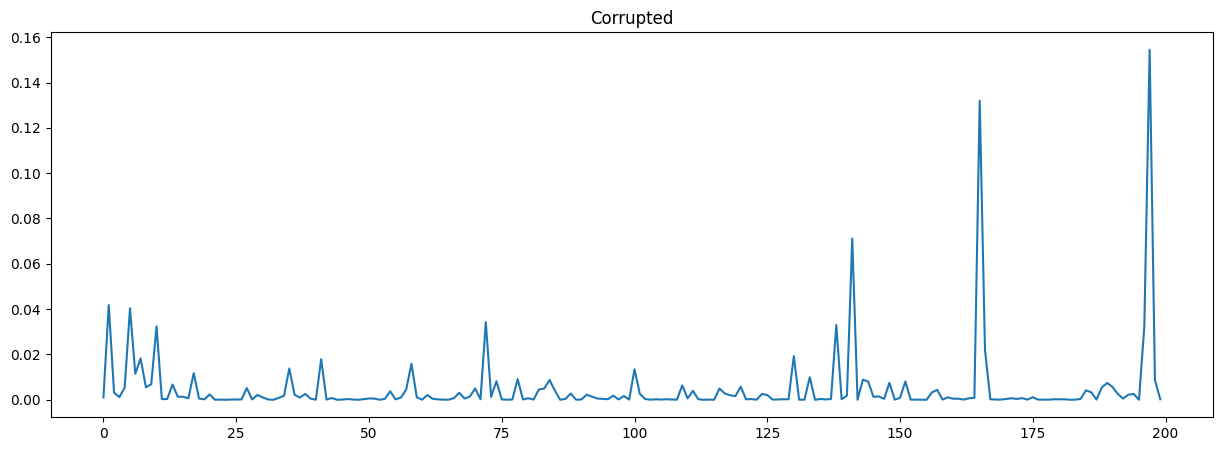

In [30]:
adapt_corrupted.to('mps')

plt.title('Corrupted')
plt.plot( torch.nn.functional.softmax( adapt_corrupted( input_corrupted.to('mps')).logits[0], 0).detach().cpu())

Classification does not improve either.

#### Overfitting with the Adam optimizer.


In [31]:
model = load_model(0)
test_time_adaptation(model, input_corrupted, repeats=64, steps=500,
                     disable_tqdm=False, logging_strategy='epoch',
                     optimizer=None
                    )

/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Loss continues to decrease over the span of training.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9682138..3.7589083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9975986..3.6634402].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.815209..3.6930351].


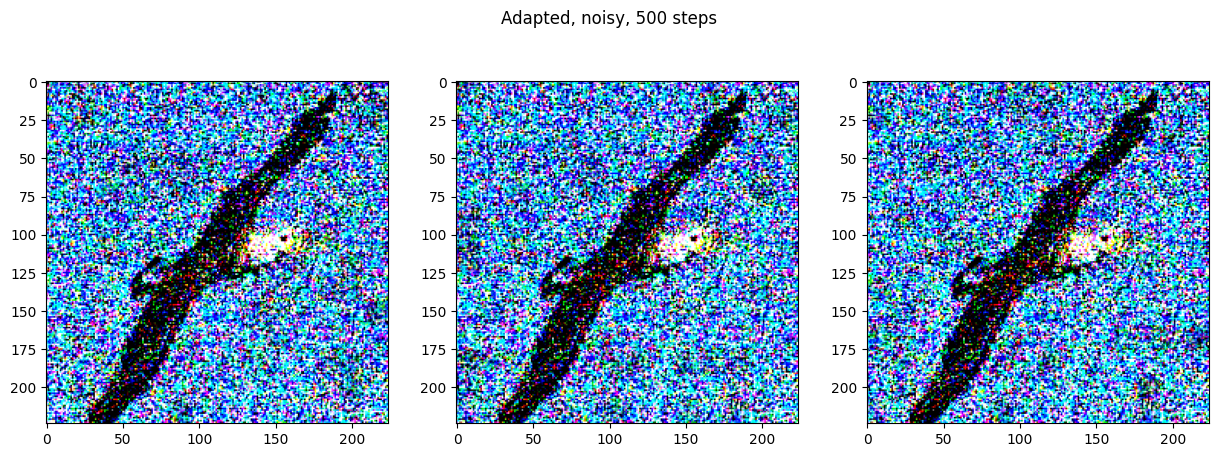

In [32]:
model.to('mps')
preds = model.embedding( torch.concat(3*[input_corrupted.to(model.embedding.device)]))

figsize(15,5)
plt.subplots(1,3)
plt.suptitle('Adapted, noisy, 500 steps')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow( model.embedding.unpatchify(preds.logits)[i].permute([1,2,0]).detach().cpu())

500 steps of adaptation allows the embedding to fit a lot of the image noise.

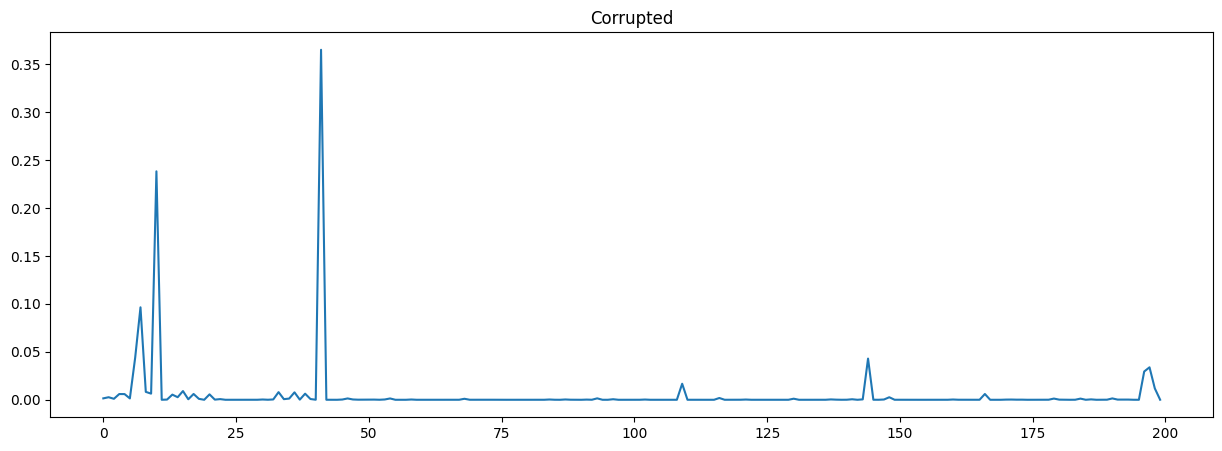

In [33]:
model.to('mps')

plt.title('Corrupted')
plt.plot( torch.nn.functional.softmax( model( input_corrupted.to('mps')).logits[0], 0).detach().cpu())

The classification outputs are different from before adaptation, but do not produce the correct answer.

#### Debugging SGD

In [4]:
model = load_model(0)

In [5]:
import inspect
from transformers import Trainer, TrainingArguments

def args_filter(args, func):
    possible_args = inspect.signature(func).parameters
    return {k: v for k, v in args.items() if k in possible_args}

def TTA_debug(model, dataset, repeats=128, steps=20, optimizer='SGD', **kwargs):
    """
        Trainer for TTA
    """
    # make sure that masking is on
    mask_ratio = kwargs.get('mask_ratio', 0.75)
    model.embedding.enable_masking(mask_ratio)

    print(model.embedding.vit.config.mask_ratio)
    model.unfreeze_all()
    model.train()

    TTA_data = torch.concat(repeats*[dataset])
    print(TTA_data.shape)

    # initialize 
    kwarg_defaults = {
                      'num_train_epochs': steps,
                      'per_device_train_batch_size': repeats,

                      'disable_tqdm': True,
                      'run_name': "DD_debug",
                      'logging_steps': 1,
                     }

    all_args = {**kwarg_defaults, **kwargs}
    training_args = TrainingArguments(**args_filter(all_args, TrainingArguments))

    if optimizer == 'SGD':
        # optimizer from the paper
        opt = torch.optim.SGD(model.embedding.parameters(), lr=1E-2, momentum=0.9, weight_decay=0.05,
                              maximize=False
                             
                             )
        optimizers = (opt, None)

    else:  # default optimized
        raise Exception('Youre debugging wrong.')

    #optimizer = AdamW(model.parameters(), **args_filter(all_args, AdamW))

    #lr_scheduler = get_cosine_with_min_lr_schedule_with_warmup(
    #    optimizer=optimizer,
    #    **args_filter(all_args, get_cosine_with_min_lr_schedule_with_warmup)
    #)

    def custom_collator(data):
        return {'pixel_values': torch.stack(data)}

    trainer = Trainer(model.embedding,
                      args=training_args,
                      train_dataset=TTA_data,
                      data_collator=custom_collator,
                      optimizers=optimizers
                      )

    return trainer

In [6]:
trainer = TTA_debug(model, input_corrupted, repeats=128, steps=20,
                     disable_tqdm=False, logging_strategy='epoch',
                     optimizer='SGD'
                    )

0.75
torch.Size([128, 3, 224, 224])


In [7]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lrast. Use `wandb login --relogin` to force relogin


/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=20, training_loss=1.8682228207588196, metrics={'train_runtime': 30.5479, 'train_samples_per_second': 83.803, 'train_steps_per_second': 0.655, 'total_flos': 2.587432448950272e+17, 'train_loss': 1.8682228207588196, 'epoch': 20.0})

In [8]:
model.embedding.vit.config.mask_ratio

0.75

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3238416..1.6473675].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2875369..1.5621556].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2450593..1.7867643].


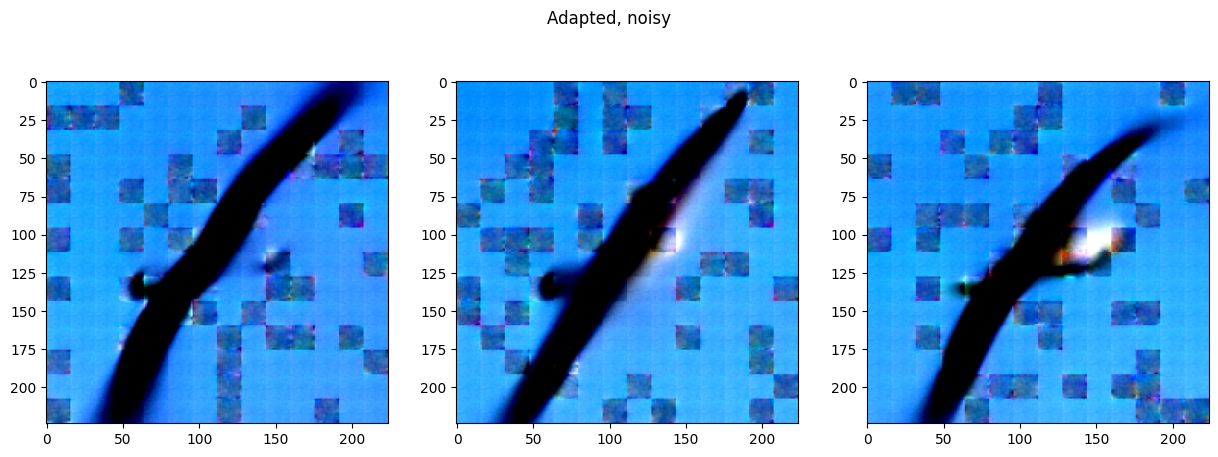

In [9]:
preds = model.embedding( torch.concat(3*[input_corrupted.to(model.embedding.device)]))

figsize(15,5)
plt.subplots(1,3)
plt.suptitle('Adapted, noisy')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow( model.embedding.unpatchify(preds.logits)[i].permute([1,2,0]).detach().cpu())

In [10]:
preds.loss.backward()

In [11]:
print("max grad:", max(p.grad.abs().max().item() for p in model.embedding.parameters() if p.grad is not None))

max grad: 0.03436046466231346


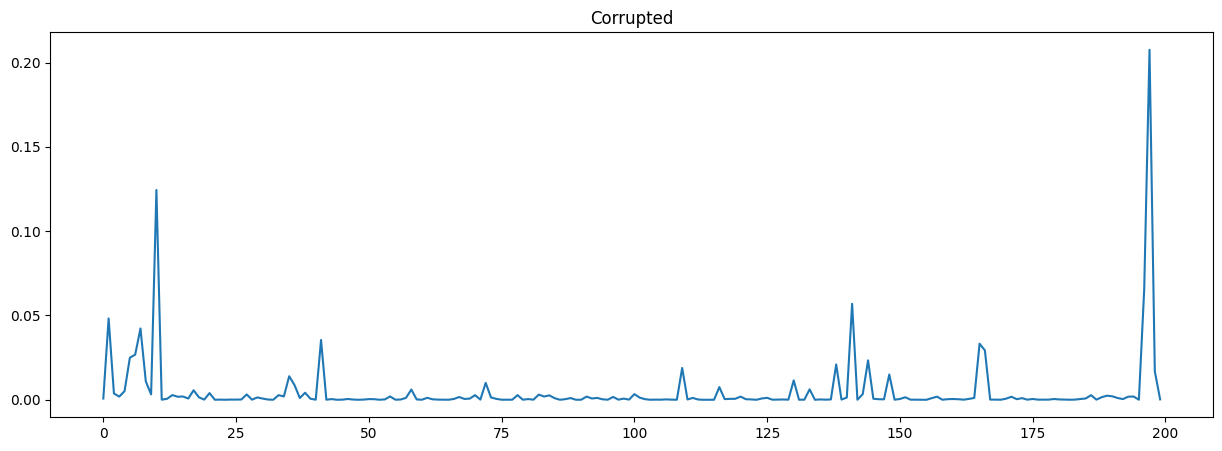

In [12]:
model.to('mps')

plt.title('Corrupted')
plt.plot( torch.nn.functional.softmax( model( input_corrupted.to('mps')).logits[0], 0).detach().cpu())

After fiddling with hyper-parameters for a while, it appears that (unsurprisingly) SGD is much more sensitive to the values of the hyper-parameters.

Furthermore (again unsurprisingly), the optimal hyper-parameters are different from the paper because the model is significantly smaller (it is the base vit-mae rather than the large vit-mae).

I believe that making this work requires a hyper-parameter sweep over the SGD hyper-parameters. To me, such a search would be equivalent to using Adam with early stopping fit by a hyper-parameter sweep, so the point made in Figure 2 of the paper is harder to defend. On second thought (returning to this), that is not the case. What matters is the degree to which improvements in reconstruction loss align with improvements in accuracy. Since the SGD hyper-parameter sweep would be performed over reconstruction loss, it could (theoretically, but not practically) be performed for all images individually.

#### 

### Overall results from TTA

First, some important points about the setting:
- vit-mae-base model, 2 layer decoder, with _AdamW_ optimizer
- Used 600 evaluation points (3 points each for 200 classes), so errorbars are fairly large ~0.04

In [2]:
results = pd.read_csv('results_cloud_run.csv')

In [42]:
results

model_layers      corruption     step0     step5    step10    step15  \
0             2  gaussian_noise  0.021667  0.133333  0.155000  0.168333   
1             2      shot_noise  0.018333  0.141667  0.160000  0.163333   
2             2   impulse_noise  0.018333  0.150000  0.163333  0.165000   
3             2    defocus_blur  0.156667  0.301667  0.285000  0.290000   
4             2      glass_blur  0.228333  0.338333  0.325000  0.323333   
5             2     motion_blur  0.188333  0.281667  0.268333  0.290000   
6             2       zoom_blur  0.123333  0.278333  0.276667  0.275000   
7             2            snow  0.090000  0.230000  0.235000  0.230000   

     step20    step25    step30  
0  0.163333  0.148333  0.143333  
1  0.160000  0.156667  0.151667  
2  0.165000  0.155000  0.155000  
3  0.293333  0.296667  0.300000  
4  0.330000  0.331667  0.333333  
5  0.286667  0.283333  0.288333  
6  0.268333  0.265000  0.278333  
7  0.215000  0.210000  0.206667

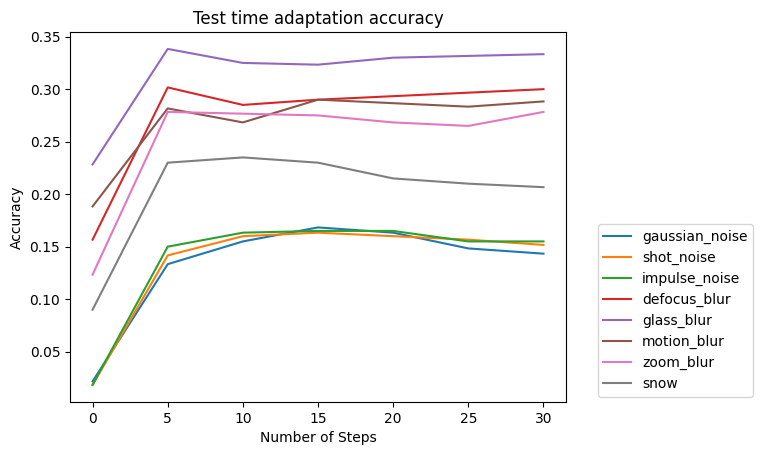

In [94]:
xs = list(range(0, 35, 5))
for i, row in results.iterrows():
    ys = [row[f'step{i}'] for i in range(0, 35,5)]
    plt.plot(xs, ys, label=row['corruption'])
    plt.legend(bbox_to_anchor=(1.05, 0.5))

plt.xlabel('Number of Steps')
plt.ylabel('Accuracy')
_=plt.title('Test time adaptation accuracy')
plt.savefig('figures/adaptation_curves.png')

This plot partially reproduces Figure 2a from Gandelsman et al, showing Accuracy as a function of the number of steps of test-time adaptation using the Adam optimizer

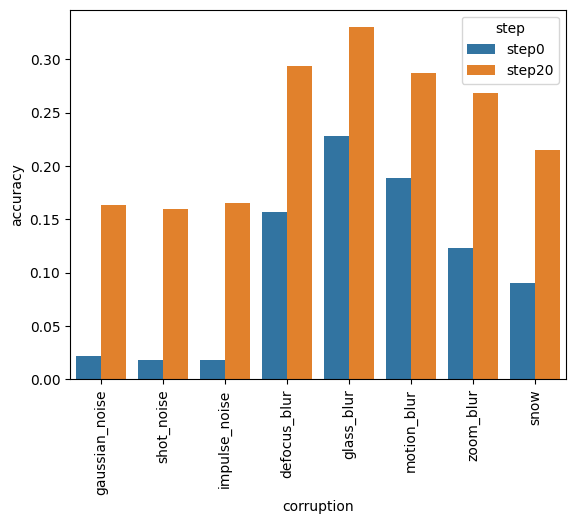

In [82]:
sns.barplot( 
    data=processed,
    x='corruption',
    y='accuracy',
    hue='step'
)
_=plt.xticks(rotation=90)

In [104]:
from scipy.stats import norm

z= norm.ppf(1-0.05/2)

wald_interval = results[['corruption', 'step0', 'step20']].copy().set_index('corruption') 
wald_interval = z / 600**0.5 * (wald_interval * (1 - wald_interval) )**0.5

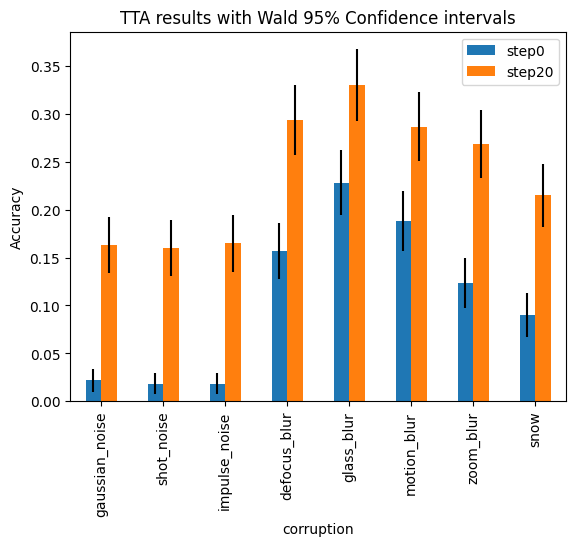

In [106]:
results[['corruption', 'step0', 'step20']].set_index('corruption').plot.bar(rot=90, yerr=wald_interval)
plt.title('TTA results with Wald 95% Confidence intervals')
plt.ylabel('Accuracy')
plt.savefig('figures/accuracy_bars.png')

This plot partially reproduces Figure 3 from Gandelsman et al: If we fix 20 steps of TTA, we see a fairly consistent accuracy improvement from Test Time Adaptation.

## Key take-aways:
__Results:__
1. We reproduce the accuracy improvement under test-time adaptation.
2. We do see some 'peaks' in accuracy when using the Adam optimizer, similar to Fig 2a. However, the number of optimization steps that we plot here is larger, and the peaks are less dramatic.


__Technical points:__
1. Test time adaptation is very resource intensive. I have only plotted 8 different corruption conditions, each sampled using only 600 datapoints. This dataset alone required 10 hours on a 4090 to compute.


__Future:__
1. Speed-up: lora, 16 bit precision
2. TTA on multiple images at once: adaptation to the dataset overall replacing image-wise adaptation. This would certainly improve speed, but decrease the effective sample size.
3. Perform fewer steps of TTA: here and in the paper, we saw most of the improvement occuring in the first couple of steps (with the Adam optimizer) 
